---
# 2. Preperation
1. Loading Packages
2. Importing raw data trimers & creating LPA domain
3. Creating trimers information

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scripts import TrimerLPA
import matplotlib.pyplot as plt
from scripts.TrimerAnalyze import medians_info
from scripts.TAhelpers import find_region, assign_region, split_rows, label_2cols

----
# 2. Creation of trimers usage frequencies input file

1. Importing the sql conenction script.
2. Connecting to the sql database.
3. Importing the required tables into the 'raw_tables' folder.

required folders -> sequence, sequence_collapse andsample_metadata

In [3]:
run_TrimerSQL = False
if run_TrimerSQL:
    import scripts.TrimerSQL as sql

    # SQL conneccot, the info_list need to contain the host ip, port, username, password and wasted database
    info_list = ["0.0.0.0", 0000, "username", "pass", "databse"]

    sql_conn = sql.mysql(input_host = info_list[0],
                         input_port = info_list[1],
                         input_username = info_list[2],
                         input_password = info_list[3],
                         input_database = info_list[4])
    
    sql_conn.import_tables()

* If raw ImmuneDB tables already exists, can use the following block to process them directly.

In [4]:
run_TrimerCreate = True
if run_TrimerCreate:
    import scripts.TrimerCreate as trimer

    trim_obj = trimer.Trimer(seqs_loc="raw_tables\\covid_vaccine_new.sequences.csv",
                                     seq_collapsed_loc="raw_tables\\covid_vaccine_new.sequence_collapse.csv", 
                                     metadata_loc="raw_tables\\covid_vaccine_new.sample_metadata.csv",
                                     metadata_list=["cell_subset", "collection_time_point_relative"],
                                     rename_metadata=True,
                                     new_metadata_names=["ab_target", "time_point"]
                                     )
    
    source_options = ["germline", "top_seq", "all_seq"][1]
    triemrs = trim_obj.create(subdatasets_list=["ab_target","time_point","subject_id"], source=source_options, save_csv=True)

> Found cleaned_seqs.csv in the procesed tables folder.
> 'cleaned_seqs.csv' loaded.
> Itirating over sub-datasets (n=30)


100%|██████████| 30/30 [11:11<00:00, 22.37s/dataset]


> Trimers and unique clones data saved to 'trimers_output' folder.


---
# 3. Processing and visualization of trimers usage LPA output

1. Creating trimer LPA object based on the LPA latent domain analysis (based on trimers signatures between documents).
2. Caclulating PCA componenets.
3. Plotting scatterplot of the LPA anaylsis.
4. Plotting heatmap of the LPA results.

In [5]:
run_TrimerLPA = True
if run_TrimerLPA:
    import scripts.TrimerLPA as trLPA

    input_dataset = "ab_target-time_point-subject_id-top_seq-trimers_[25.09.25-12;09].csv"
    raw_trimer = pd.read_csv(f"trimers_data\\{input_dataset}", index_col=0)

    trimer_lpa = trLPA.TrimerLPA(input_data=f"trimers_data\\{input_dataset}", min_treshold=100) #creating trimer LPA object
    pca, var = trimer_lpa.pca() # performing PCA analysis

> The following document havn't met the treshold (100):
                  document  frequency_in_document
19  Spike+MemB.1baseline.7                      2
24     Spike+MemB.2weeks.7                     41
26     Spike+MemB.4weeks.4                     62


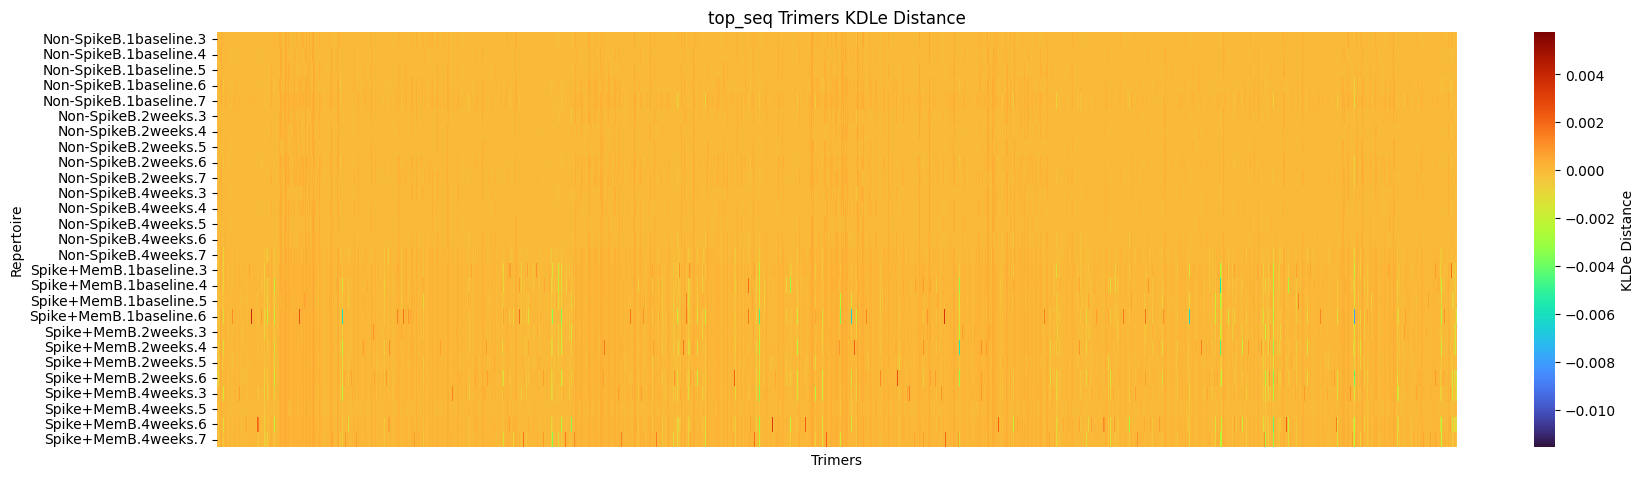

In [6]:
# Plotting heatmap of the KLDe distances
trimer_lpa.plot_heatmap(trimers_origin="top_seq") # Plotting heatmap of the LPA distances

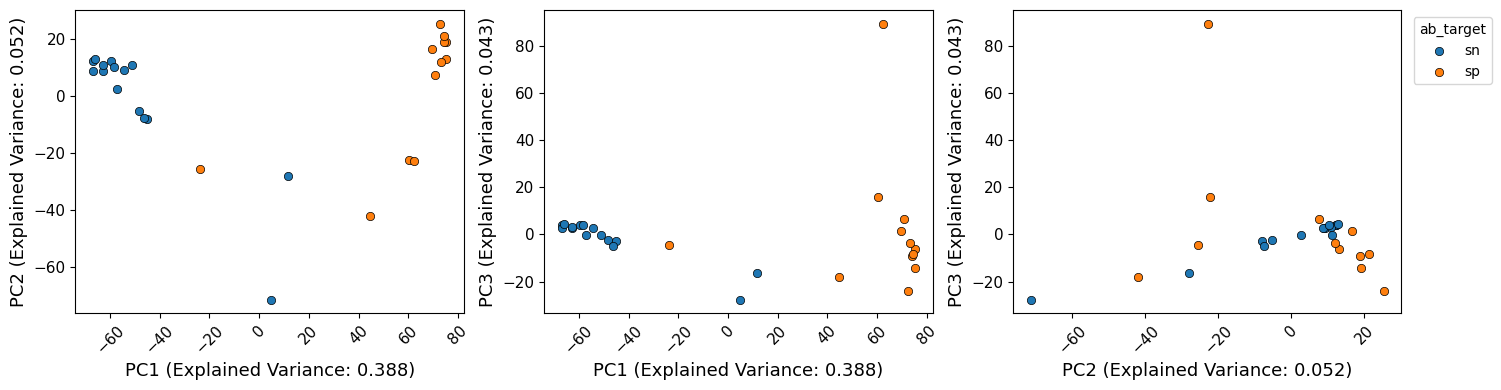

In [7]:
# Plotting scatterplot of the PC results
var_list = [round(i,3) for i in var.Variance.values]

pca1_df = pca
pca1_df.columns = [f"PC{i}" for i in range(1,pca1_df.shape[1]+1)]

# unique ab_target types

index_i = 0
values = pca1_df.index.str.split(".").to_series().apply(lambda x : x[index_i]).unique()

fig, axs = plt.subplots(1,3, figsize=(15,4))

for ab in values:
    cond_slice = (pca1_df.index.str.split(".").to_series().apply(lambda x : x[index_i]) == ab).values
    dataset_slice = pca1_df[cond_slice]

    PCs = ["PC"+str(i) for i in range(1,4)]
    for i,j in zip([0,1,2],[[1,2],[1,3],[2,3]]):
        PCi = f"PC{j[0]}"
        PCj = f"PC{j[1]}"

        axs[i].scatter(dataset_slice[PCi], 
                       dataset_slice[PCj], 
                       label=ab,
                       edgecolor="black",
                       lw=0.5)

        axs[i].tick_params(axis="both", labelsize=11)
        axs[i].tick_params(axis="x", rotation=45)
        axs[i].set_xlabel(PCi + f" (Explained Variance: {str(var_list[j[0]-1])})", fontsize=13)
        axs[i].set_ylabel(PCj + f" (Explained Variance: {str(var_list[j[1]-1])})", fontsize=13)
    
plt.legend(labels=["sn", "sp"], title="ab_target",loc="upper right", bbox_to_anchor=(1.25, 1) )

plt.tight_layout()
plt.show()

----
# 4. Analyzing trimers usage

* Extreame positive and negative medians of KLDe subtition survival found in the previous analysis (diversity analysis)

In [8]:
# positions from previus analysis
pa_positions = [ 28,  29,  30,  31,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  99,
       100, 101, 102, 103,  98]

pa_head = [ 98,  86,  41,  83,  38,  81, 102,  75,  89,  44,  46,  37,  40, 51,  79,  94,  39,  48]
pa_tail = [ 64,  59,  58,  90,  92,  65,  87, 101,  62,  74,  95,  66,  57, 69,  55,  45,  68,  85]
 
pa_joined = pa_head +  pa_tail

In [9]:
# raw trimers csv path
raw_trimers_path ="trimers_data\\ab_target-time_point-subject_id-top_seq-trimers_[10.05.25-20;02].csv" 

# importing the raw trimers and selecting only cdr/fw rows
raw_trimers = pd.read_csv("trimers_data\\ab_target-time_point-subject_id-top_seq-trimers_[10.05.25-20;02].csv", index_col=0)
raw_trimers = raw_trimers[raw_trimers.region.isin(['cdr1', 'fw2', 'cdr2', 'fw3'])]

# Adding metadata derived from label column to the raw trimers dataframe
raw_trimers = label_2cols(raw_trimers, {0:"ab_target", 1:"time_point", 2:"subject_id"})#, mapper={0:{"Non-SpikeB":"sn", "Spike+MemB":"sp"}})

# creating LPA distances object for signatures dataframe
trimer_lpa = TrimerLPA.TrimerLPA(input_data=raw_trimers_path, min_treshold=100)

> The following document havn't met the treshold (100):
                  document  frequency_in_document
19  Spike+MemB.1baseline.7                      2
24     Spike+MemB.2weeks.7                     41
26     Spike+MemB.4weeks.4                     62


In [10]:
# creating df of trimers ordered by positions
trimers_order = raw_trimers.groupby("trimer").agg({"first_aa": lambda X : int(X.value_counts().index[0])}).reset_index().sort_values(by="first_aa")

* Importing the TrimerAnalyze script.
* Using the TrimerAnalysis script in order to analyze certerin trimers presence in positions.

In [11]:
to_save = False
to_save_mds = False
from scripts import TrimerAnalyze 

trimer_init = TrimerAnalyze.TrimerAnalysis(trimer_input=raw_trimers_path) #inititating the class
trimer_divr = trimer_init.diversity_analysis(save_csv=to_save, div_orders= [0, 1, 2, 3]) #creating position analysis
trimer_count = trimer_init.trimer_presence(save_csv=to_save, index_labels = {0:"ab_target", 1:"time_point", 2:"subject_id"}, diversity=[1,2]) #creating trimers analysis

Prelimenary Visualization
1. Creating medians for LPA distances of trimers from the domain
2. Filtring and orgenizing the trimers data by the medians LPA distance 
3. Visualizing the medians distances distribution (by histogram)
4. Visualizing the mean presence in unique position (x-axis) for each trimer in regads to it's mean median (y-axis)

In [12]:
medians = medians_info(raw_trimers = raw_trimers,
                      lpa_sig = trimer_lpa.sig_df,
                      index_unique = {0:["Non-SpikeB", "Spike+MemB"]},
                      index_name="ab_target")

medians_filt = medians.filter_sort(on="Spike+MemB_median",
                                   sort_ascending=False,
                                   filter_how="qnt",
                                   save_csv=to_save_mds)

> 3891 unique trimers in divresity of order 1. Producing histogram.


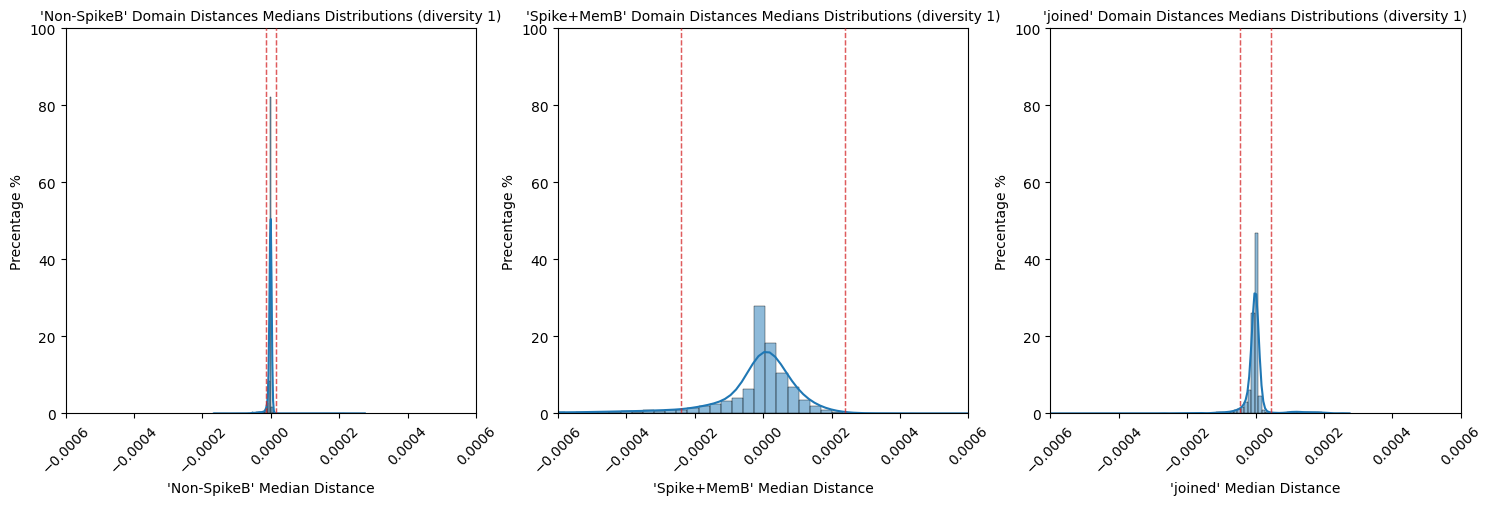

In [13]:
medians.plot_median_hist(trimer_pres=trimer_count,
                         div=1,
                         xy_limit=(-0.0006, 0.0006, 0, 100), 
                         save_fig=to_save_mds)

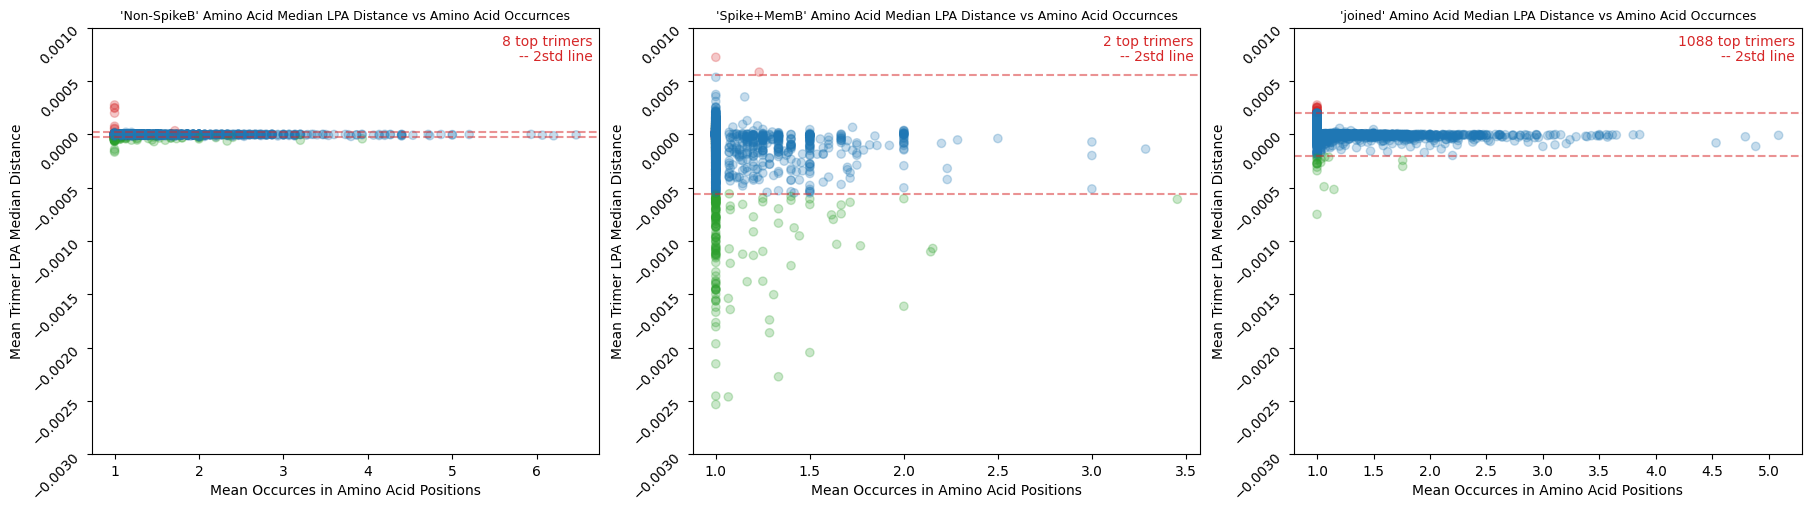

> Non-precense trimers were dropped from the figure, the top trimers count != 25% of the trimers 
> Non-precense trimers still have median distance due to the scoring method.


In [14]:
top_trimers = medians.plot_median_presence(trimer_pres=trimer_count, 
                                           div_pres=1,
                                           stat="2std",
                                           return_data=True,
                                           save_fig=to_save_mds)

---
# 5. Extreame negative and positive trimers analysis

In [15]:
# Heatmap that presents the 
def heatmap_trimers(trimers_input : pd.DataFrame,
                    remove_v1 : bool = False,
                    remove_v0 : bool = True,
                    fig_height : int = 10,
                    div : int = 1,
                    show_fig : bool = True):
    """
    Takes a trimers informative dataframe and visualizing trimers occurnces across different subjects
    as heatmap plot.

    trimers_input : pd.DataFrame -> takes dataframe of trimers with columns of '['subject_id', 'trimer', 'div1_unqpos', 'div1_ncount']'.
    remove_v1 : bool -> replace cells with values smaller than 1 with zeros.
    remove_v0 : bool -> removes rows with the sum of 0.
    fig_height : int -> height of the plot.
    div : int -> order of diversity in analysis.
    show_fig : bool -> show the pyplot figure output.
    """
    
    heatmap_trimers = pd.DataFrame(index = trimers_input.trimer.unique(),
                                   columns= [str(i) for i in range(28,105)],
                                   data=0)

    for sid in trimers_input.subject_id.unique():
        temp_df = trimers_input[trimers_input.subject_id == sid]

        for i in temp_df.iterrows():
            i_trimer, i_pos, i_count = i[1]["trimer"], str(i[1][f"div{div}_unqpos"]), int(i[1][f"div{div}_ncount"])

            if i_trimer in temp_df.trimer.values: 
                heatmap_trimers.loc[i_trimer, i_pos] += 1

    # Removing <1 points
    if remove_v1:
        mask_bool = (heatmap_trimers != 1) 
        heatmap_trimers = heatmap_trimers[mask_bool].fillna(0).astype("int")


    # Removing rows with sum of 0 from plot
    if remove_v0:
        nonzero_rows = (heatmap_trimers.sum(axis=1) != 0)
        heatmap_trimers = heatmap_trimers[nonzero_rows.values]

    heatmap_array, heatmap_cols, heatmap_index = heatmap_trimers.to_numpy(), heatmap_trimers.columns, heatmap_trimers.index

    fig, ax = plt.subplots(1,1, figsize=(16,fig_height))
    sns.heatmap(heatmap_array, ax=ax, cbar_kws={'label': 'Occurrences in Unique Subjects'})
    ax.set_xticks(labels=heatmap_cols, ticks=range(0,77))
    ax.set_xticklabels(labels=heatmap_cols, rotation=90)
    ax.set_yticks(labels=heatmap_index, ticks=range(0,len(heatmap_index)), rotation=0)


    ax.set_xlabel("Unique Trimer")
    ax.set_ylabel("Amino Acid Position")

    range_cdr = list(range(27,39)) + list(range(56,66)) #CDR1, CDR2
    for xtick, xcolor in zip(ax.get_xticklabels(), ["tab:red" if i in range_cdr else "black" for i in heatmap_cols.astype("int")]):
        xtick.set_color(xcolor)

    if show_fig == False:
        plt.close()

    return heatmap_trimers

In [17]:
# diversity of the analysis
div = 1 #diversity order
trimer_count_copy = trimer_count.copy().fillna(0)

# Data of the high medians trimers
filt_high1 = top_trimers['Spike+MemB'].index
filt_high2 = medians_filt[medians_filt["Spike+MemB_median_qnt"] == 1].trimer.unique() #relevent trimers (top median)
relv_high = trimer_count_copy[(trimer_count_copy.trimer.isin(filt_high2)) & (trimer_count_copy[f"div{div}_npos"] != 0)]

# Data of the low median trimers.
filt_low = medians_filt[medians_filt["Spike+MemB_median_qnt"] == 0.25].trimer.unique() #relevent trimers (bottom median)
relv_low = trimer_count_copy[(trimer_count_copy.trimer.isin(filt_low)) & (trimer_count_copy[f"div{div}_npos"] != 0) & (trimer_count_copy[f"div{div}_npos"].notnull())]

# Dataframe of the analysis
pipeline_df = relv_high

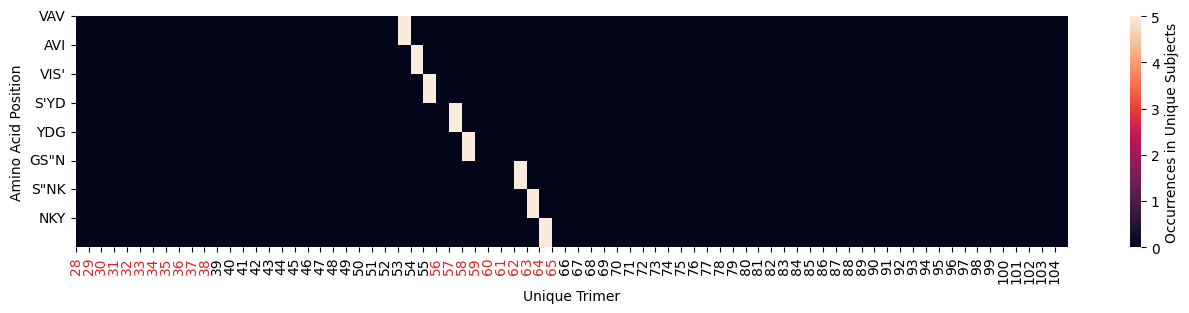

In [18]:
ab_targets = ["Spike+MemB", "Non-SpikeB"]

div = 1
rtimer_count_cp = trimer_count.fillna(0)
rtimer_count_cp = split_rows(rtimer_count_cp[(rtimer_count_cp[f"div1_npos"] != 0) & 
                                             (rtimer_count_cp.trimer.isin(filt_high2)) & 
                                             (rtimer_count_cp.ab_target==ab_targets[0])], div=1)

cp_grouped = rtimer_count_cp.groupby(["subject_id","trimer", f"div{div}_unqpos"]).agg({f"div{div}_ncount":"sum"}).reset_index()
cp_grouped["div1_unqpos"] = cp_grouped["div1_unqpos"].astype("int")
cp_grouped.sort_values("div1_unqpos", inplace=True)

heatmap_sp_sp = heatmap_trimers(cp_grouped,remove_v0=True, remove_v1=True, fig_height=3, show_fig=True)

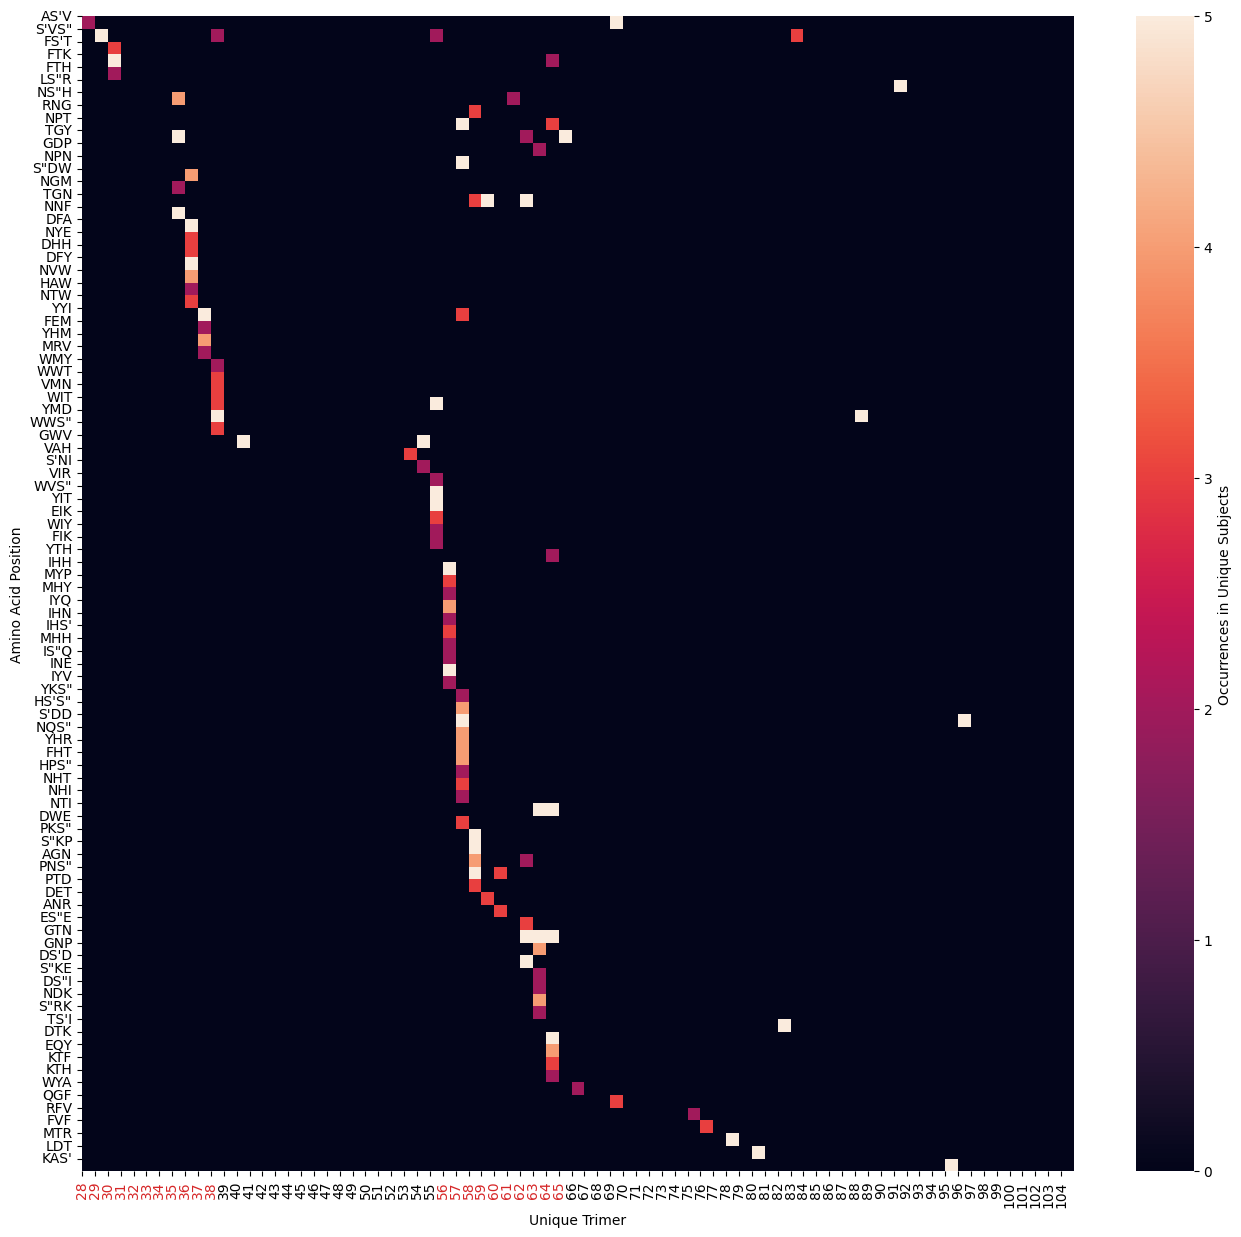

In [19]:
# Sorting the medians_filt dataframe by the SN median values
medians_filt_SN = medians.filter_sort(on="Non-SpikeB_median",
                                      sort_ascending=False,
                                      filter_how="qnt",
                                      save_csv=False)

# Getting a list of the top precentile trimers (unique)
filt_high3 = medians_filt_SN[medians_filt_SN["Non-SpikeB_median_qnt"] == 1].trimer.unique() #relevent trimers (top median - by SN)

# List of ab_target types
ab_targets = ["Spike+MemB", "Non-SpikeB"]

# Getting relevent SN top trimers values
div = 1
rtimer_count_SN = trimer_count.fillna(0)
rtimer_count_SN = split_rows(rtimer_count_SN[(rtimer_count_SN[f"div1_npos"] != 0) & 
                                             (rtimer_count_SN.trimer.isin(filt_high3)) & 
                                             (rtimer_count_SN.ab_target==ab_targets[1])], div=1)
SN_grouped = rtimer_count_SN.groupby(["subject_id","trimer", f"div{div}_unqpos"]).agg({f"div{div}_ncount":"sum"}).reset_index()
SN_grouped["div1_unqpos"] = SN_grouped["div1_unqpos"].astype("int")
SN_grouped.sort_values("div1_unqpos", inplace=True)

heatmap_sn_sp = heatmap_trimers(SN_grouped, remove_v0=True, remove_v1=True, fig_height=15)

----
# 6. Analysis of clones possessing the found genetic motif

* Codon Table 
* Translation Function
* Motif

In [20]:
# aa codon table
codon_dic_updated = {
                'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
                'TCT': "S'", 'TCC': "S'", 'TCA': "S'", 'TCG': "S'",
                'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',  # * for STOP
                'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',

                'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
                'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
                'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
                'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',

                'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
                'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
                'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
                'AGT': 'S"', 'AGC': 'S"', 'AGA': 'R', 'AGG': 'R',

                'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
                'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
                'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
                'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
                }

aa_list = ["F", "L", "S'", "Y", "*", 
           "C", "W", "P", "H", "Q", 
           "R", "I", "M", "T", "N", 
           "K", 'S"', "R", "V", "A", 
           "D", "E", "G"]

# Translating nt sequence
def nt_transalte_104(nt_seq):
    rem3 = len(nt_seq) % 3

    if rem3 != 0:
        nt_seq = nt_seq[:-rem3]

    translated = []
    seq_len = len(nt_seq)

    for i in range(1, int((seq_len+3)/3)):
        codon = nt_seq[i*3-3:i*3]
    
        if codon in list(codon_dic_updated.keys()):
            aa = codon_dic_updated[codon]  
        else:
            aa = "-"
            
        translated.append(aa)
    
    return translated

In [21]:
# list of the found motif amino acids 
motif_list = ["V", "A", "V", "I", "S'", "Y", "D", "-", "-", 'G', 'S"', "N", "K", "Y"]
motif_array = np.array(motif_list)
motif_str = "".join(motif_list)

In [22]:
dropped_labels = [("sp")]

* Creating motif object
* Importing sequences dataset to python
* Cleaning the data (renaming values in ab_target and time_point columns)

In [23]:
# Importing sequence dataset
cl_seqs = pd.read_csv("trimers_processed_tables\\cleaned_seqs.csv", index_col=0)

# Changing the metadata values
cl_seqs["time_point"] = cl_seqs["time_point"].apply(lambda X : X[0])
cl_seqs["ab_target"] = cl_seqs["ab_target"].map({"Non-Spike B":"sn", "Spike+ Mem B":"sp"})
cl_seqs["subject_id"] = "subj_" + cl_seqs.subject_id.astype("str")
cl_seqs = cl_seqs[["clone_id", "sequence", "germline", "copy_number", "subject_id", "ab_target", "time_point"]]

# Getting the top sequence rows only
idx = cl_seqs.groupby('clone_id')['copy_number'].idxmax()
cl_seqs = cl_seqs.loc[idx,:]

# Translating both germline and top sequence to amino acids
# cl_seqs["germ_aa"] = cl_seqs["germline"].apply(lambda X : "".join(nt_transalte_104(X)))
# cl_seqs["seq_aa"] = cl_seqs["sequence"].apply(lambda X : "".join(nt_transalte_104(X)))
cl_seqs["germ_aa"] = cl_seqs["germline"].apply(lambda X : np.array(nt_transalte_104(X)))
cl_seqs["seq_aa"] = cl_seqs["sequence"].apply(lambda X : np.array(nt_transalte_104(X)))

# Getting the relevent motif aa sequence (54-66): VAV ISYD..GSNK Y
cl_seqs["germ_5366"] = cl_seqs["germ_aa"].apply(lambda X : X[52:66])
cl_seqs["seq_5366"] = cl_seqs["seq_aa"].apply(lambda X : X[52:66])

# Final cleanup
cl_seqs = cl_seqs[["clone_id", "germ_aa", "seq_aa", "germ_5366", "seq_5366", "subject_id", "ab_target", "time_point"]]

# Adding labels per seq
cl_seqs["label_s"] = cl_seqs.ab_target + "." + cl_seqs.time_point.astype("str")
cl_seqs["label_l"] = cl_seqs["label_s"] + "." + cl_seqs.subject_id.astype("str")

# Dropping labels filtered out in the previous analysis
filt_labels = ["sp.1.subj_7", "sp.2.subj_7", "sp.4.subj_4"]
cl_seqs = cl_seqs[cl_seqs.label_l.isin(filt_labels) == False]


In [24]:
# If germ / seq is the motif equal to 1
# can compare arrays with np.array_equal()
cl_seqs[["germ_motif", "seq_motif"]] = 0,0 
cl_seqs.loc[(cl_seqs["germ_5366"].apply(lambda X : "".join(X) == motif_str)), "germ_motif"] = 1
cl_seqs.loc[(cl_seqs["seq_5366"].apply(lambda X : "".join(X) == motif_str)), "seq_motif"] = 1
cl_seqs.loc[(cl_seqs["seq_5366"].apply(lambda X : sum(X == motif_list) > 0.8*len(motif_list))), "seq_motif_80p"] = 1


# How many amino acids are equal compared to the motif (not including spacers)
cl_seqs["germ_neq"] = cl_seqs["germ_5366"].apply(lambda X : sum(X == motif_array) - list(X).count("-"))
cl_seqs["seq_neq"] = cl_seqs["seq_5366"].apply(lambda X : sum(X == motif_array)- list(X).count("-"))

# Diffrence between number of motif amino acids in germline compared to top sequence
cl_seqs["motif_diff"] = cl_seqs.germ_neq - cl_seqs.seq_neq

In [25]:
cl_seqs.groupby("label_s").agg({"germ_motif":lambda X : X.sum()/len(X)})

,germ_motif
label_s,
sn.1,0.069653
sn.2,0.068842
sn.4,0.070132
sp.1,0.218384
sp.2,0.163751
sp.4,0.138104


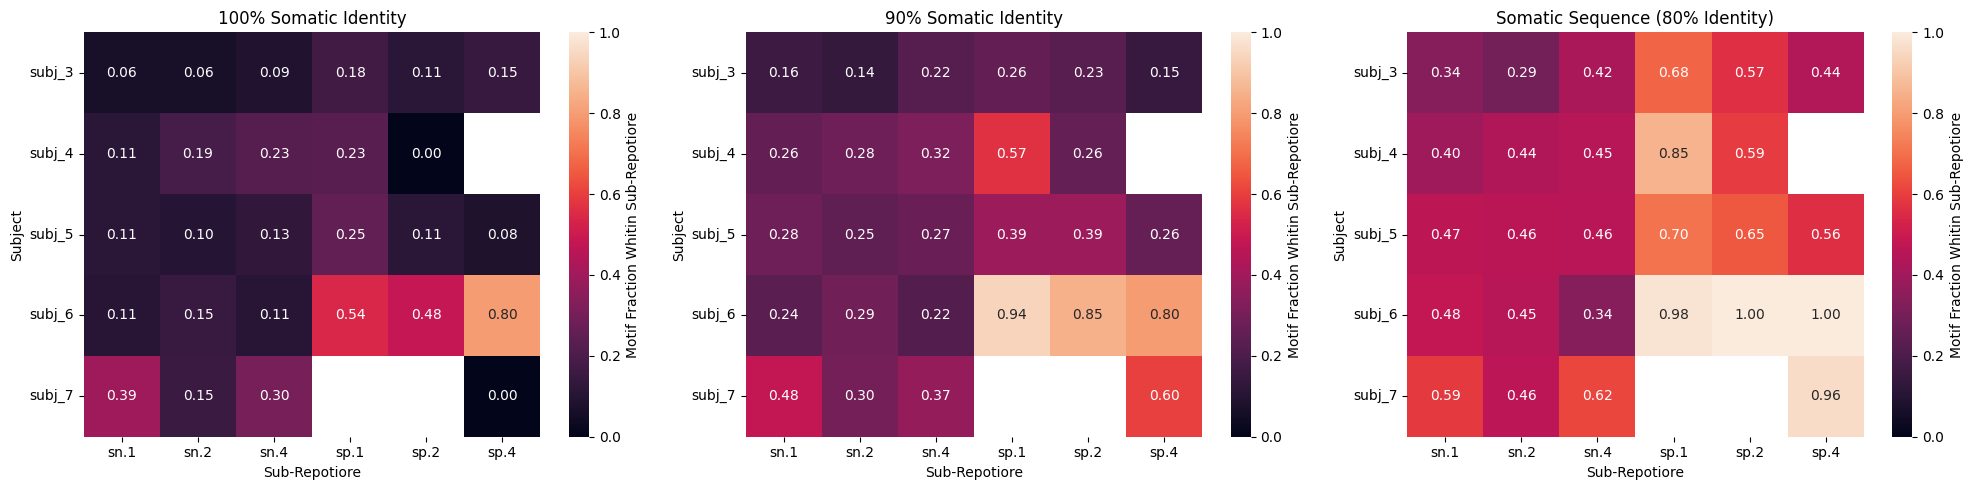

In [27]:
only_germ_motif = cl_seqs.copy()[cl_seqs.germ_motif == 1]
only_germ_motif.loc[(only_germ_motif["seq_5366"].apply(lambda X : sum(X == motif_list) > 0.9*len(motif_list))), "seq_motif_90p"] = 1

label_dict = {"seq_motif":"100% Somatic Identity", 
              "seq_motif_90p":"90% Somatic Identity",
              "seq_motif_80p":"Somatic Sequence (80% Identity)"}

fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i,j in zip(["seq_motif","seq_motif_90p","seq_motif_80p"], (0,1,2)):
    source = i
    ax = axs[j]

    unique_subjects, unique_labels = only_germ_motif.subject_id.unique(), only_germ_motif.label_s.unique()
    result_freqs = pd.DataFrame(index=unique_subjects, columns= unique_labels)
    conditions = [(i,j) for i in np.sort(unique_subjects) for j in np.sort(unique_labels)]

    for cnd in conditions:
        temp_ser =  only_germ_motif.loc[(only_germ_motif.subject_id == cnd[0]) & (only_germ_motif.label_s == cnd[1]), source]
        if len(temp_ser) == 0:
            result_freqs.loc[cnd[0], cnd[1]] = np.nan
        
        else:
            result_freqs.loc[cnd[0], cnd[1]] = temp_ser.sum()/len(temp_ser)

    result_freqs = result_freqs.astype("float")[np.sort(result_freqs.columns)]

    sns.heatmap(result_freqs,
                vmin=0,
                vmax=1, 
                ax=ax, 
                cbar_kws={'label': 'Motif Fraction Whitin Sub-Repotiore'},
                annot=True,
                fmt='.2f')
    
    ax.set_title(label_dict[i])
    ax.tick_params(axis='y', labelrotation=0)
    ax.set_xlabel("Sub-Repotiore")
    ax.set_ylabel("Subject")

plt.tight_layout()
plt.show()